Generating data for lambda = 0
Generating data for lambda = 0.3
Generating data for lambda = 0.8
Generating data for lambda = 1.0


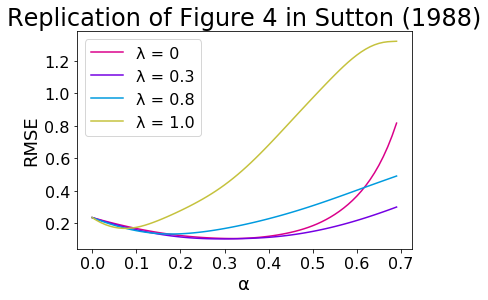

In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for experiments_______________________________________________________________
# Switches for choosing which figure to generate                                               |
run_3 = False # 8.5 minutes runtime                                                            |
run_4 = True# 1.5 minutes runtime                                                            |
run_5 = False # 18 minutes runtime_____________________________________________________________|
                                                          
# The target actual values
actual_values = np.array([1/6, 1/3, 1/2, 2/3, 5/6])

# Parameters for generating figure 3
training_sets_fig3 = 10
training_sequences_fig3 = 100
iterations_fig3 = 20
alpha_fig3 = 0.001
color_fig3 = '#da008a'

# Parameters for generating figure 4
training_sets_fig4 = 100
training_sequences_fig4 = 10
alphas_fig4 = np.array(range(70)) / 100
lambdas_fig4 = [0, 0.3, 0.8, 1.0]
colors_fig4 = ['#da008a', '#7400e3', '#009bdf', '#c5c23d']

# Parameters for generating figure 5
training_sets_fig5 = 100
training_sequences_fig5 = 10
alphas_fig5 = np.array(range(71)) / 100
lambdas_fig5 = np.array(range(51)) / 50
color_fig5 = '#00ddac'

# Font sizes for all plots
title_size = 24
label_size = 18
tick_size = 16
legend_size = 16

# Define functions for generating plot data
#-----------------------------------------------------------------------------------------------
def take_a_walk(num_steps, start_step, seq_per_set, num_sets, seed=-1):
    """
    Create a list of lists of training sequences for random walks.
    :param num_steps: The number of steps in the random walk
    :param start_step: The starting step of the sequences. -1 for random
    :param seq_per_set: Number of training sequences in each training set
    :param num_sets: Number of training sets 
    :param seed: The random seed to use for generating steps. Use -1 for no seed
    :return training: Training data. Access a sequence (matrix) with training[set][seq]
    """
    # Set the random seed, if supplied
    if seed > 0:
        np.random.seed(seed)
    # Preallocate the entire training data list of lists of NumPy arrays
    training = num_sets * [seq_per_set * [None]]
    # Iterate to build the training data randomly
    for this_set in range(num_sets): # Each set
        for seq in range(seq_per_set): # Each sequence
            if start_step == -1: # Random start location
                start_step = np.random.randint(1, num_steps)
            # Initialize the sequence
            step = start_step
            sequence = np.zeros(num_steps).astype(int)
            sequence[step] = 1
            while (step != 0 and step != num_steps - 1): # While not in absorbing state
                if np.random.uniform() >= 0.5: # Uniformly random L v R step
                    step += 1 # Go right
                else:
                    step -= 1 # Go left
                # Generate the vector representing this step
                this_sequence = np.zeros(num_steps).astype(int)
                # Set the appropriate element to 1
                this_sequence[step] = 1
                # Add this step to the sequence
                sequence = np.vstack((sequence, this_sequence))
            # Assign the sequence to its position in the training data
            training[this_set][seq] = sequence
    return training

#-----------------------------------------------------------------------------------------------
def learn_game(t_seq, lambda_val, alpha, z_vals, p, verbose=False):
    """
    Given a set of training data, perform repeated weight updates as in eq 4 in Sutton (1988)
    :param t_seq: The input training sequence
    :param lambda_val: ...lambda.
    :param alpha: Learning rate
    :param z_vals: A tuple of the form (r for state 0, r for state[-1])
    :param p: The weights coming in
    :param verbose: Set to True to see values generated at each step
    :return delta_w: A NumPy vector of weight values
    """
    # Determine the number of steps taken in the sequence, by the number of rows
    num_steps = t_seq.shape[0] - 1
    # Number of non-terminal states
    num_states = t_seq.shape[1] - 2
    # Get the reward value
    z = z_vals[t_seq[-1, -1]]
    # Initialize the lambda sequence and weight updates
    lambda_seq = np.ones(1)
    just_one = np.ones(1)
    delta_w = np.zeros(num_states)
    # Chop off the reward step data
    training = t_seq[:-1, 1:-1]
    # Perform the weight updates
    for step in range(num_steps):
        these_steps = training[0:step + 1]
        if verbose:
            print('p =', p)
            print('Training sequence:')
            print(these_steps)
            print('Lambda sequence:')
            print(lambda_seq)
            print('Lambda sequence * training sequence:')
            print(np.sum(these_steps * lambda_seq[:, None], axis=0))
        if step == num_steps - 1: # The step entering the absorbing state
            if verbose: print("z =", z)
            delta_p = z - np.dot(p, training[-1, :])
        else: # Non-terminal state
            delta_p = np.dot(p, training[step + 1, :]) - np.dot(p, training[step, :])
        if verbose: print('delta_p =', delta_p)
        delta_w += alpha * delta_p * np.sum(these_steps * lambda_seq[:, None], axis=0)
        if verbose: print('delta_w =', delta_w)
        lambda_seq = np.concatenate((lambda_seq * lambda_val, just_one))
    return(delta_w)

# Experiment code
#-----------------------------------------------------------------------------------------------
if run_3: # Generate figure 3
    # Generate a random walk
    training = take_a_walk(7, 3, training_sequences_fig3, training_sets_fig3, 27)
    # Setup initial RMSE vector
    RMSE_vector = np.zeros(101)
    for lambda_it in range(101):
        # Reset weights and deltas
        weights = 0.5 * np.ones(5)
        deltas = np.zeros(5)
        for iteration in range(iterations_fig3):
            for tset in range(training_sets_fig3):
                for tseq in range(training_sequences_fig3):
                    deltas += learn_game(t_seq=training[tset][tseq], lambda_val=lambda_it / 100, 
                        alpha=alpha_fig3, z_vals=(0, 1), p=weights)
                weights += deltas
                deltas = np.zeros(5)
        RMSE_vector[lambda_it] = np.sqrt(((weights - actual_values) ** 2).mean())
        print(str(lambda_it) + '% done')

    # Plot RMSE vs lambda
    plt.plot(RMSE_vector, color=color_fig3)
    plt.ylabel('RMSE', fontsize=label_size)
    plt.xlabel('λ', fontsize=label_size)
    plt.xticks([0, 20, 40, 60, 80, 100], ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], 
        fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.title('Replication of Figure 3 in Sutton (1988)', fontsize=title_size)

if run_4: # Generate figure 4
    # Generate a random walk
    training = take_a_walk(7, 3, training_sequences_fig4, training_sets_fig4, 27)
    # Setup initial RMSE vector
    RMSE_mat = np.zeros((len(lambdas_fig4), len(alphas_fig4)))
    for ix, lambda_it in enumerate(lambdas_fig4): # Iterate over each lambda value
        print('Generating data for lambda = ' + str(lambda_it))
        for ii, alpha in enumerate(alphas_fig4): # Iterate over each alpha value
            for tset in range(training_sets_fig4):
                weights = 0.5 * np.ones(5) # Reset the weights
                for tseq in range(training_sequences_fig4):
                    # Generate the weights
                    weights += learn_game(t_seq=training[tset][tseq], lambda_val=lambda_it, 
                        alpha=alpha, z_vals=(0, 1), p=weights)
                    # Add the new RMSE to the RMSE matrix
                    RMSE_mat[ix, ii] += np.sqrt(((np.round(weights, decimals=20) - 
                        actual_values) ** 2).mean())
    # Divide the RMSE matrix by the number of training sets to get the average per-set error
    RMSE_mat /= training_sets_fig4 * training_sequences_fig4

    # Plot RMSE vs alpha for each lambda
    for ix, lambda_pl in enumerate(lambdas_fig4):
        plt.plot(alphas_fig4, RMSE_mat[ix, :], label='λ = ' + str(lambda_pl), 
            color=colors_fig4[ix])

    # Format and show the plot
    plt.xlabel('α', fontsize=label_size)
    plt.ylabel('RMSE', fontsize=label_size)
    plt.legend(loc='best', fontsize=legend_size)
    plt.title('Replication of Figure 4 in Sutton (1988)', fontsize=title_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)

if run_5: # Generate figure 5
    # Generate a random walk
    training = take_a_walk(7, 3, training_sequences_fig5, training_sets_fig5, 27)
    # Setup initial RMSE vector
    RMSE_mat = np.zeros((len(lambdas_fig5), len(alphas_fig5)))
    for ix, lambda_it in enumerate(lambdas_fig5): # Iterate over each lambda value
        print('Generating data for lambda = ' + str(lambda_it))
        for ii, alpha in enumerate(alphas_fig5): # Iterate over each alpha value
            for tset in range(training_sets_fig5):
                weights = 0.5 * np.ones(5) # Reset the weights
                for tseq in range(training_sequences_fig5):
                    # Generate the weights
                    weights += learn_game(t_seq=training[tset][tseq], lambda_val=lambda_it, 
                        alpha=alpha, z_vals=(0, 1), p=weights)
                    # Add the new RMSE to the RMSE matrix
                    RMSE_mat[ix, ii] += np.sqrt(((np.round(weights, decimals=20) - 
                        actual_values) ** 2).mean())
    # Divide the RMSE matrix by the number of training sets to get the average per-set error
    RMSE_mat /= training_sets_fig5 * training_sequences_fig5

    # Now get the minimum RMSE for each value of lambda (that is, for each row)
    RMSE_plot = RMSE_mat.min(axis=1)

    # Plot RMSE vs lambda
    plt.plot(lambdas_fig5, RMSE_plot, color=color_fig5)

    # Format and show the plot
    plt.ylabel('RMSE using best α', fontsize=label_size)
    plt.xlabel('λ', fontsize=label_size)
    plt.title('Replication of Figure 5 in Sutton (1988)', fontsize=title_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    
# Show the plot 
plt.show()